In [1]:
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
# --------------------------------------------------------
# References:
# timm: https://github.com/rwightman/pytorch-image-models/tree/master/timm
# DeiT: https://github.com/facebookresearch/deit
# MAE: https://github.com/facebookresearch/mae
# DropPos: https://github.com/Haochen-Wang409/DropPos
# --------------------------------------------------------

import math
from functools import partial
from typing import Type, TypedDict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from jaxtyping import Float, Int, Bool
from src.data.components.sampling_utils import sample_and_stitch
from src.models.components.utils.part_utils import (
    compute_gt_transform,
    get_all_pairs_subset,
)
from torch import Tensor
from src.models.components.partmae_v2 import PARTMaskedAutoEncoderViT, PART_mae_vit_base_patch16



In [2]:
model = PART_mae_vit_base_patch16(pos_mask_ratio=0.75, mask_ratio=0.75).eval()
batch = torch.randn(2, 3, 224, 224)

In [3]:
with torch.no_grad():
    model(batch)

In [4]:
import hydra
from omegaconf import OmegaConf

with hydra.initialize(version_base=None, config_path="../../configs"):
    cfg = hydra.compose(
        config_name="train.yaml",
        overrides=[
            # "experiment=partmae_im1k",
            "experiment=pretrain/imagenet1k/partmae_v2/vit_b_16/4060ti",
            "data.num_workers=0",
        ],
    )
    OmegaConf.register_new_resolver("eval", eval)
datamodule = hydra.utils.instantiate(cfg.data)
datamodule.setup("fit")
train_dataloader = datamodule.train_dataloader()
train_iter = iter(train_dataloader)
batch = next(train_iter)


/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'train_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['train_transform'])`.
/home/dgcnz/development/thesis/PART/.venv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'test_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['test_transform'])`.
INFO:HFDataModule:Loading datasets.


Loading dataset shards:   0%|          | 0/257 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/25 [00:00<?, ?it/s]

INFO:HFDataModule:Finished setting up datasets.


In [5]:
batch = batch["image"]

Running forward pass using initialization: kaiming_uniform_4
kaiming_uniform_4 tensor(0.3298)


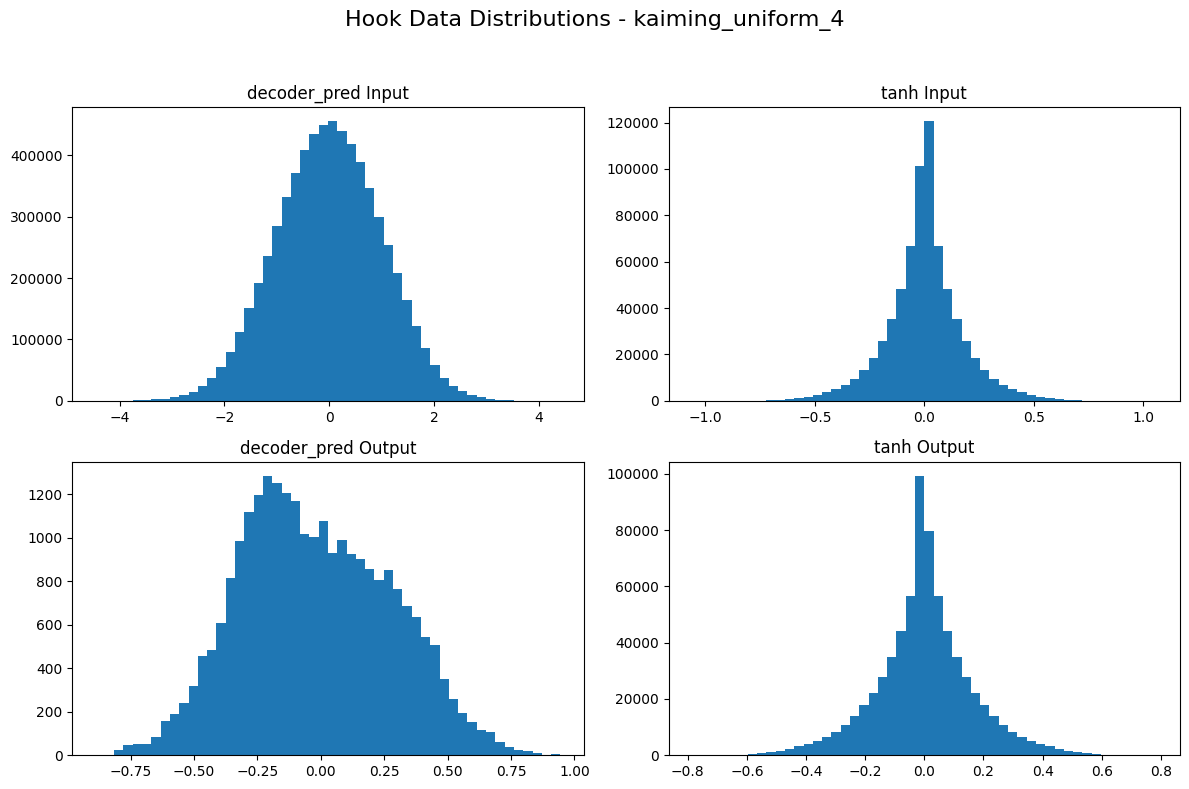

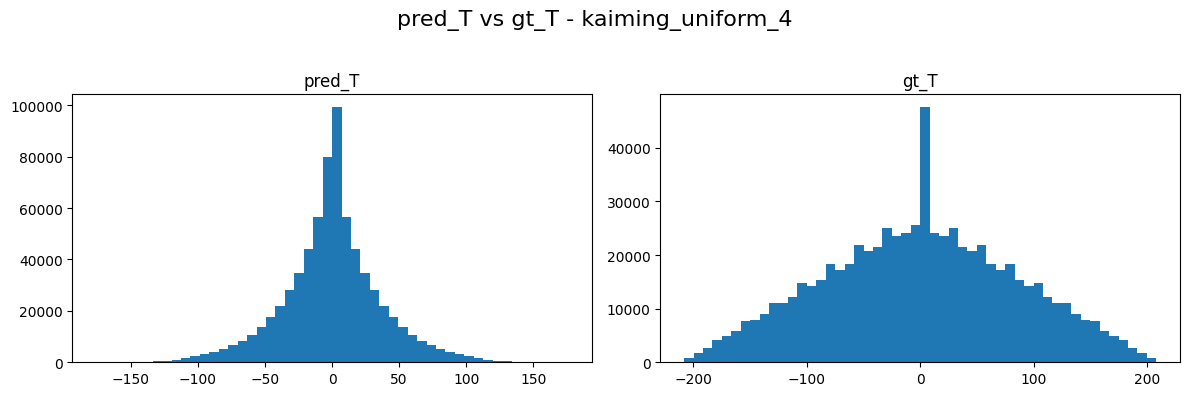

Running forward pass using initialization: kaiming_uniform_3
kaiming_uniform_3 tensor(0.3355)


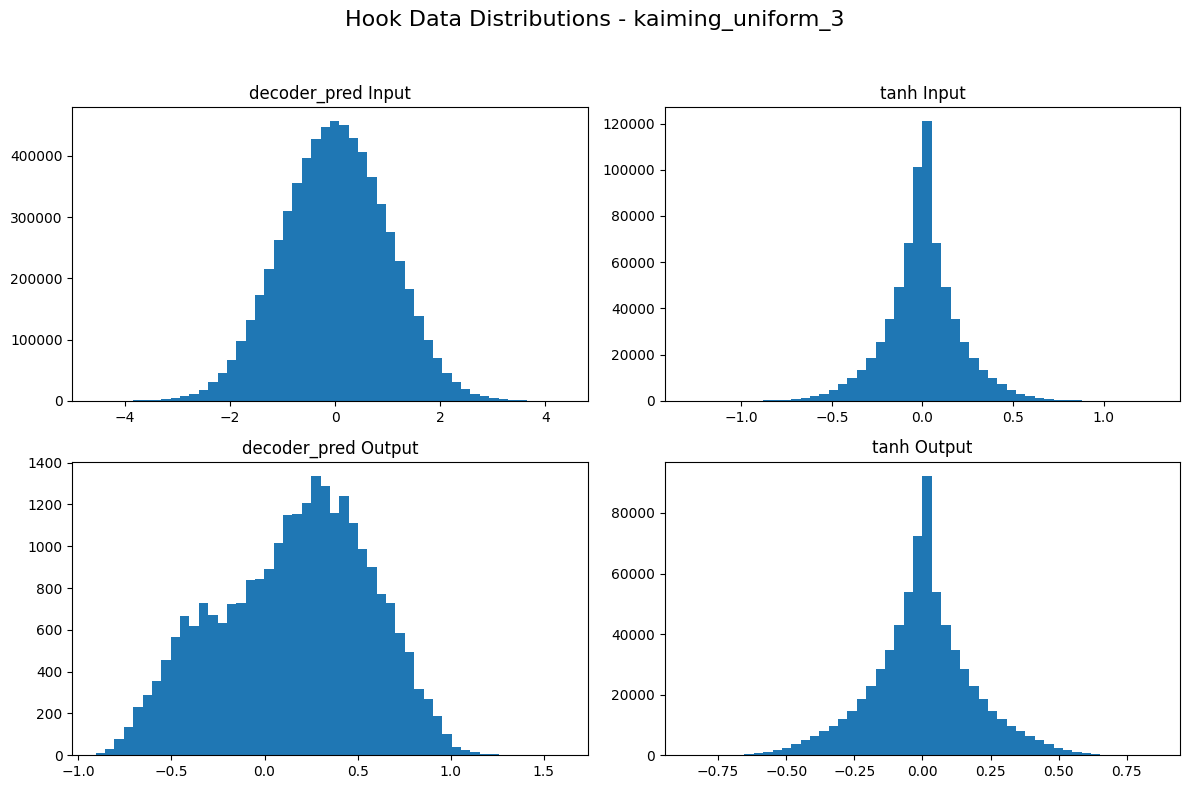

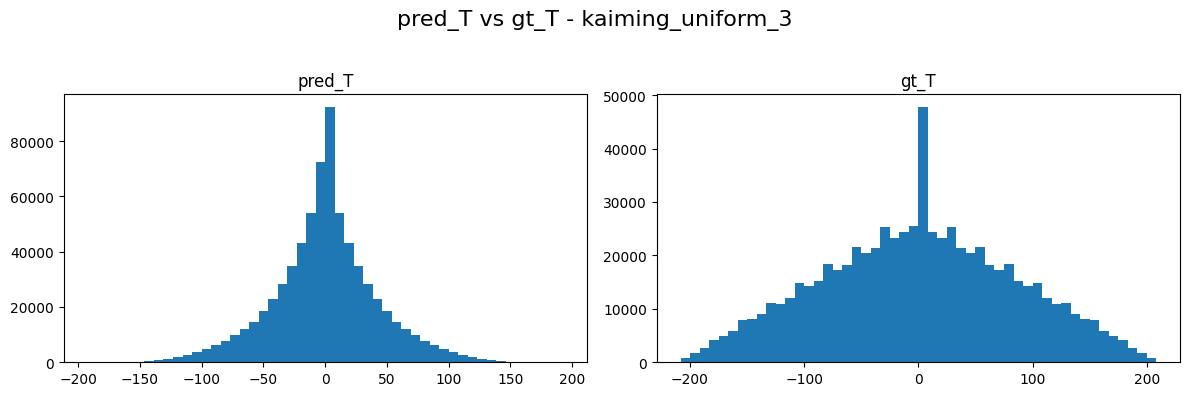

Running forward pass using initialization: kaiming_uniform_2
kaiming_uniform_2 tensor(0.3652)


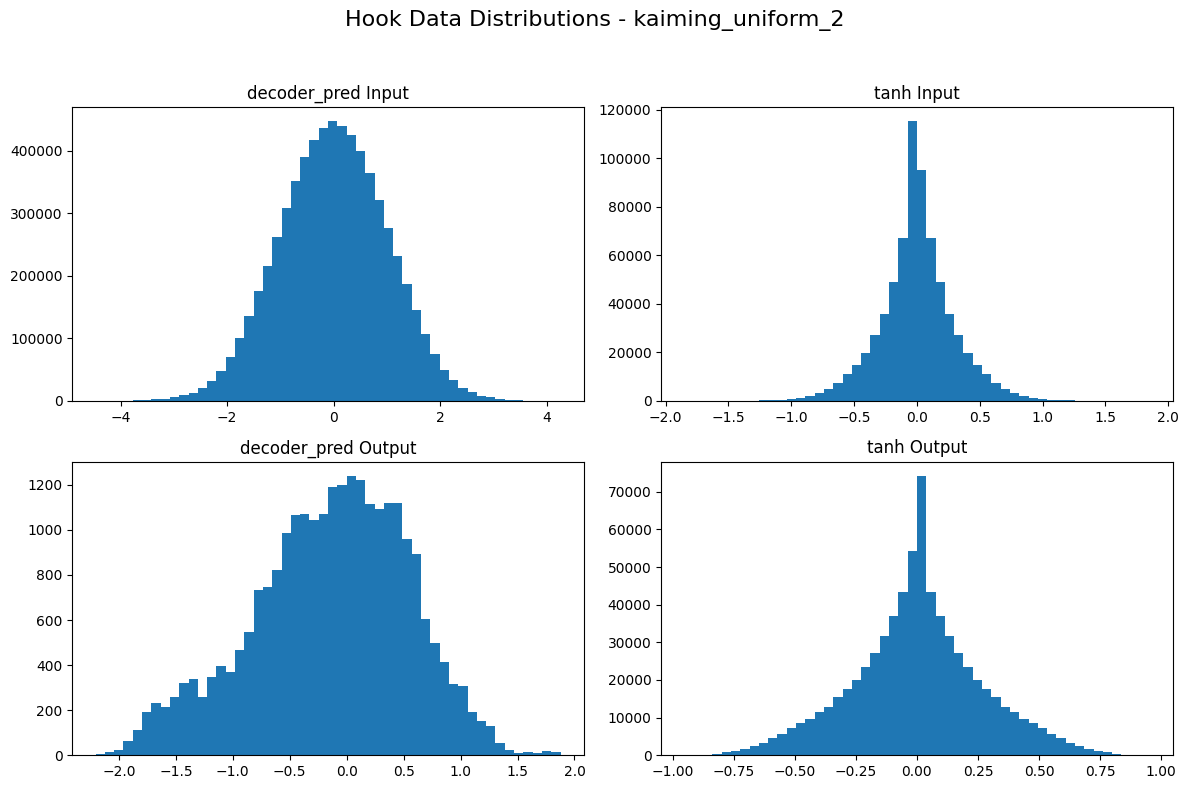

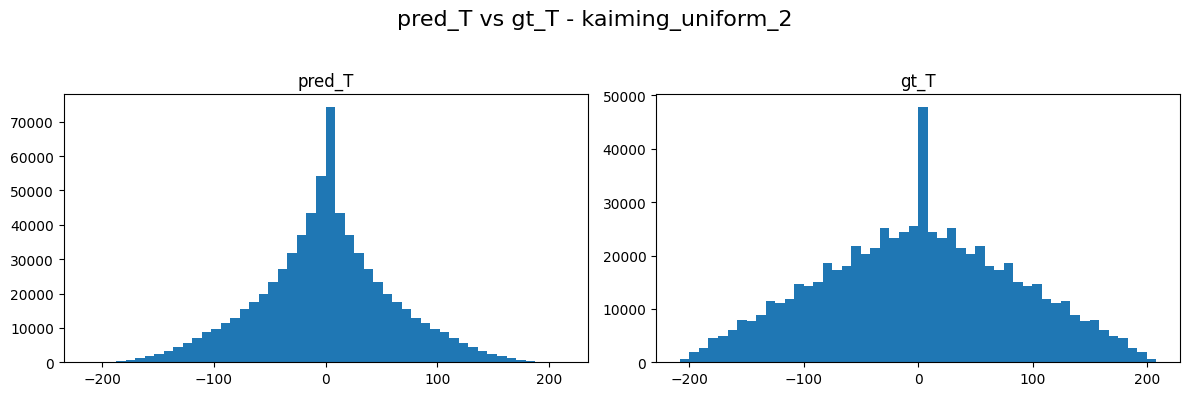

Running forward pass using initialization: kaiming_uniform_1
kaiming_uniform_1 tensor(0.4447)


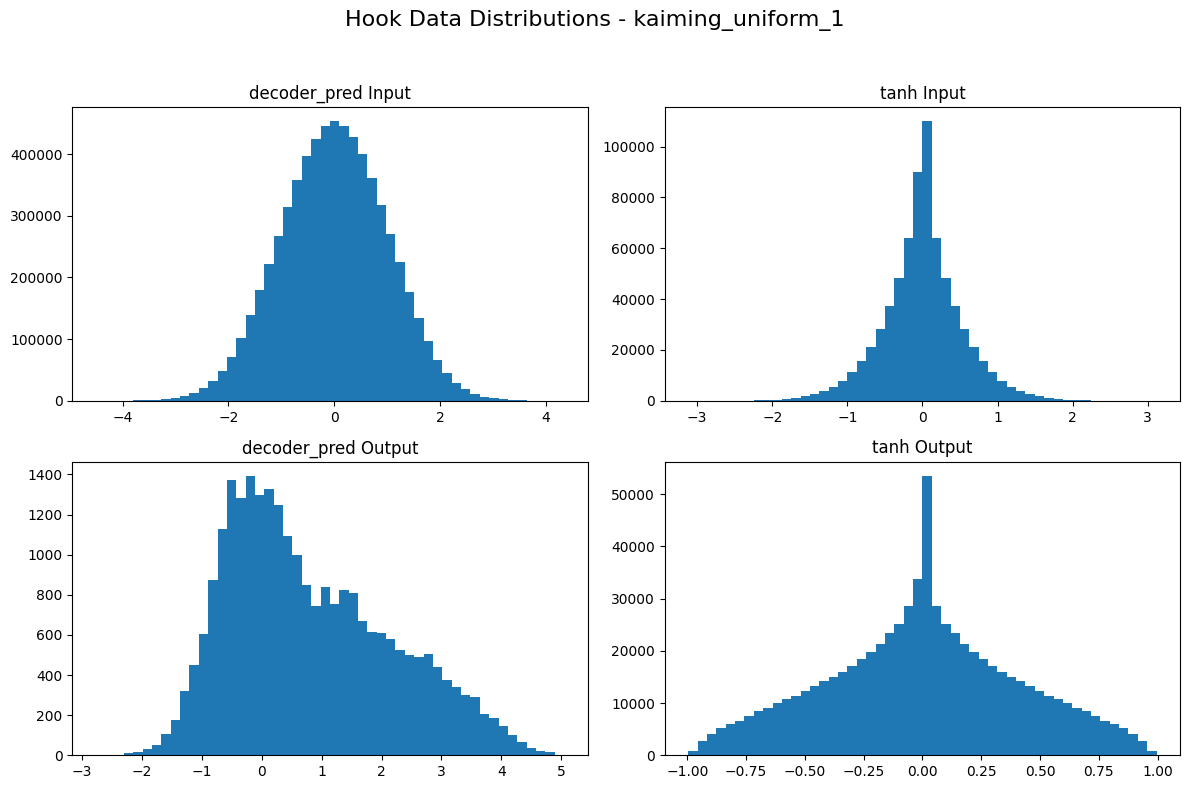

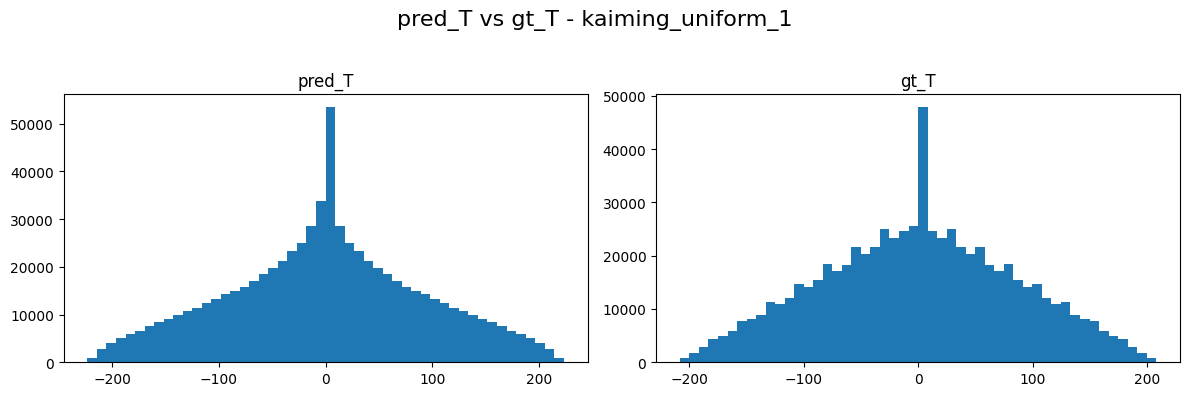

In [7]:
import matplotlib.pyplot as plt
import torch

# Dictionary to store hook data.
hook_data = {}

def get_hook(name):
    def hook(module, inputs, output):
        hook_data[name] = {
            "input": inputs[0],
            "output": output,
        }
    return hook

def plot_distributions(init_name: str, model: torch.nn.Module, batch: torch.Tensor):
    """
    Runs a forward pass with the given model and batch, captures the inputs/outputs from
    model.decoder_pred and model.tanh, then plots their histogram distributions.
    
    Args:
        init_name (str): Name of the initialization being tested.
        model (torch.nn.Module): The model to test.
        batch (torch.Tensor): Input batch for a forward pass.
    """
    # Clear any previous hook data.
    global hook_data
    hook_data = {}

    # Register hooks.
    handle_decoder_pred = model.decoder_pred.register_forward_hook(get_hook("decoder_pred"))
    handle_tanh = model.tanh.register_forward_hook(get_hook("tanh"))

    # Run a forward pass.
    with torch.no_grad():
        out = model(batch)
    
    print(init_name, out["loss"])

    # Retrieve and flatten hook data.
    dp_in  = hook_data["decoder_pred"]["input"].flatten().detach().cpu().numpy()
    dp_out = hook_data["decoder_pred"]["output"].flatten().detach().cpu().numpy()
    tanh_in  = hook_data["tanh"]["input"].flatten().detach().cpu().numpy()
    tanh_out = hook_data["tanh"]["output"].flatten().detach().cpu().numpy()

    # Plot a 2x2 grid of histograms.
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs[0, 0].hist(dp_in, bins=50)
    axs[0, 0].set_title("decoder_pred Input")
    axs[0, 1].hist(tanh_in, bins=50)
    axs[0, 1].set_title("tanh Input")
    axs[1, 0].hist(dp_out, bins=50)
    axs[1, 0].set_title("decoder_pred Output")
    axs[1, 1].hist(tanh_out, bins=50)
    axs[1, 1].set_title("tanh Output")
    fig.suptitle(f"Hook Data Distributions - {init_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Separately, plot histograms for pred_T and gt_T from the model's output.
    pred_T_hist = out["pred_T"].flatten().detach().cpu().numpy()
    gt_T_hist   = out["gt_T"].flatten().detach().cpu().numpy()
    fig2, axs2 = plt.subplots(1, 2, figsize=(12, 4))
    axs2[0].hist(pred_T_hist, bins=50)
    axs2[0].set_title("pred_T")
    axs2[1].hist(gt_T_hist, bins=50)
    axs2[1].set_title("gt_T")
    fig2.suptitle(f"pred_T vs gt_T - {init_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Remove hooks.
    handle_decoder_pred.remove()
    handle_tanh.remove()


# Example usage:
# Assume your model is defined and you have a valid input batch.
# For example, assuming a model instance and a dummy batch:
# model = ... 
# batch = torch.randn(2, 3, 224, 224)

# Define a dictionary of different initialization functions.
# Each function takes the model, and its purpose is to reinitialize model.decoder_pred weights.
inits = {
    "kaiming_uniform_4": lambda model: torch.nn.init.kaiming_uniform_(model.decoder_pred.weight, a=4),
    "kaiming_uniform_3": lambda model: torch.nn.init.kaiming_uniform_(model.decoder_pred.weight, a=3),
    "kaiming_uniform_2": lambda model: torch.nn.init.kaiming_uniform_(model.decoder_pred.weight, a=2),
    "kaiming_uniform_1": lambda model: torch.nn.init.kaiming_uniform_(model.decoder_pred.weight, a=1),
    # Add additional initialization functions here.
}

# Iterate over initializations and test.
for init_name, init_func in inits.items():
    # Reinitialize the decoder_pred weights.
    init_func(model)
    print(f"Running forward pass using initialization: {init_name}")
    plot_distributions(init_name, model, batch)